# 4 Support Vector Machines

## Loading the data and required packages

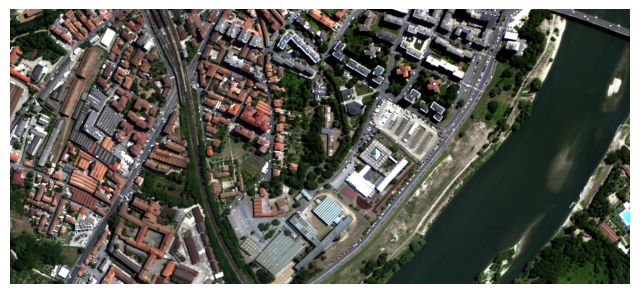

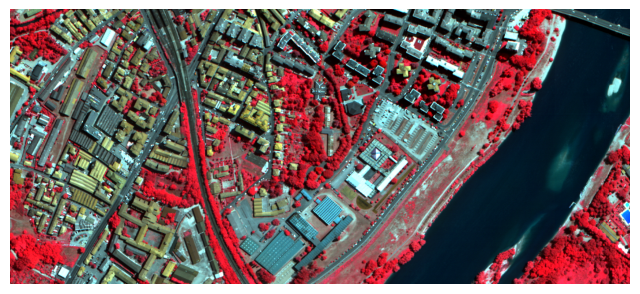

In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

path = "C:/Users/louis/Desktop\Hyperspectral Remote Sensing/Sheet04/data"

image_path = f"{path}/rosis_pavia.tif"
image = rasterio.open(image_path)
image_data = image.read()

# this replaces the stretch='lin'
def linear_stretch(band, lower_percent=2, upper_percent=98):
    
    lower = np.percentile(band, lower_percent)
    upper = np.percentile(band, upper_percent)    # Clip and scale
    stretched_band = np.clip(band, lower, upper)
    stretched_band = (stretched_band - lower) / (upper - lower)
    return stretched_band
    
band15 = linear_stretch(image_data[15])   
band30 = linear_stretch(image_data[30])  
band43 = linear_stretch(image_data[43])
band_nir = linear_stretch(image_data[80])

# stacks
rgb = np.dstack((band43, band30, band15))
nir_rg = np.dstack((band_nir, band43, band30))

plt.figure(figsize=(8, 8))
plt.imshow(np.rot90(rgb, k=-1)) #rotating for smaller notebook
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(np.rot90(nir_rg, k=-1)) #rotating for smaller notebook
plt.axis('off')
plt.show()


### Q4.1 (1 pt): 
Which band combination is suitable for a false color NIR/R/G composite? Remember that ROSIS
is a half range sensor.

**Answer:** 80 for NIR seems to be suitable, producing an image that looks similar in color to the one from the last training (that was double the range and used 40).

| 0.00, 0.00, 0.32|
| 0.00,-0.00, 1.00|
| 0.00, 0.00, 1.00|

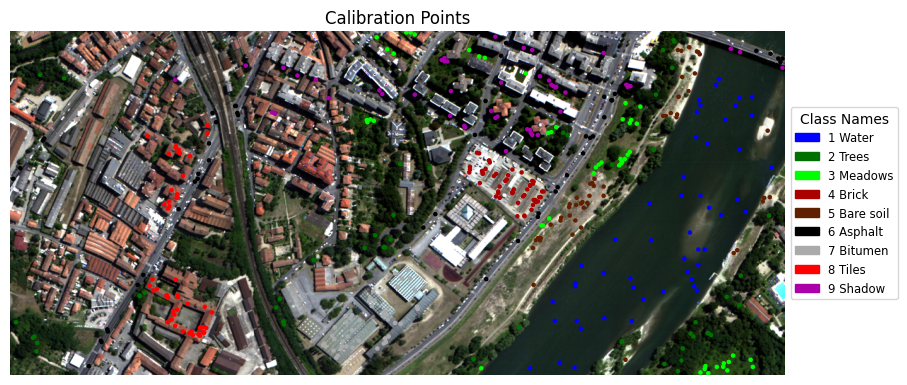

In [4]:
import shapefile
from matplotlib.patches import Patch

# Transform shapefile coordinates to image coordinates
transform = image.transform
print(transform)

cal_sf = shapefile.Reader(f"{path}/rosis_calpoints.shp")

# coordinates to pixel indices
def coord_to_pixel(x, y, transform):
    col, row = ~transform * (x, y)
    return int(col), int(row)

# we will need this later for the val points too
def extract(sf):
    sf_shapes = sf.shapes()
    sf_records = sf.records()

    class_values = [record[1] for record in sf_records]

    # x and y coordinates
    shpx = [shape.points[0][0] for shape in sf_shapes]
    shpy = [shape.points[0][1] for shape in sf_shapes]

    pixel_coords = [coord_to_pixel(x, y, transform) for x, y in zip(shpx, shpy)]
    cols, rows = zip(*pixel_coords)

    return cols, rows, shpx, shpy, class_values

cal_cols, cal_rows, cal_x, cal_y, cal_class_values = extract(cal_sf)

colors = ["#0000FF", "#007000", "#00FF00", "#AA0000", "#602000", "#000000",
          "#AAAAAA", "#FF0000", "#AA00AA"]

#print(cal_class_values)
# dict classes : colors
class_to_color = {cls: colors[i] for i, cls in enumerate(sorted(set(cal_class_values)))}

#show rgb again
plt.figure(figsize=(10, 6))
plt.imshow(np.rot90(rgb, k=-1))
plt.title('Calibration Points')
plt.axis('off')

# we also need to rotate the scatter
height, width, _ = rgb.shape

# and overlay points + legend
point_colors = [class_to_color[cls] for cls in cal_class_values]
plt.scatter(y=cal_cols, x=[height - col - 1 for col in cal_rows], c=point_colors, s=5) 

class_names = ["1 Water", "2 Trees", "3 Meadows", "4 Brick",
    "5 Bare soil", "6 Asphalt", "7 Bitumen", "8 Tiles", "9 Shadow"]

legend_handles = [Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]

plt.legend(handles=legend_handles, loc='center left', fontsize='small', ncol=1, title="Class Names", bbox_to_anchor=(1, 0.5))

plt.show()

### Q4.2 (1 pt): 
Do your recognise additional land cover types that are not represented by the calibration points?

**Answer:** There is a railroad through the city that is not covered. The railway ballast appears red, maybe some kind of granite, and will be mapped to brick later. There are also other types of roofs (than tiles), sometimes with solar panels on them. (Although they do not directly count as land cover types, cars are not mapped.)

## Preparing the classification

In [5]:
points = list(zip(cal_x, cal_y))

# Extract reflectance values 
cal_ref_gen = image.sample(points)
cal_ref = np.array([val for val in cal_ref_gen])

# keeping only valid bands
#cal_ref[cal_ref > 65530] = np.nan
#print(np.isnan(cal_ref).any(axis=0)) # all valid this time
#valid_bands = ~np.isnan(cal_ref).any(axis=0)
#cal_ref = cal_ref[:, valid_bands]

## Visualization of the spectra

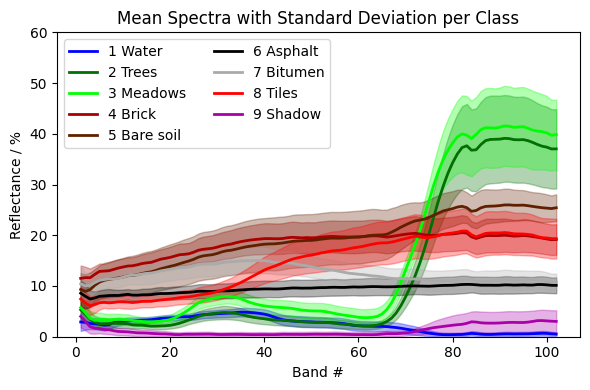

In [6]:
unique_classes = np.unique(cal_class_values)
band_numbers = np.arange(1, 103)

fig, ax = plt.subplots(figsize=(6, 4))

for i, cls in enumerate(unique_classes):
    # Get indices and spectra for the class
    class_indices = [idx for idx, val in enumerate(cal_class_values) if val == cls]
    spectra_class = cal_ref[class_indices, :]

    m = np.nanmean(spectra_class, axis=0) / 100
    std = np.nanstd(spectra_class, axis=0) / 100

    ax.plot(band_numbers, m, color=colors[i], linewidth=2, label=class_names[i])

    # Fill mean +- standard deviation
    ax.fill_between(band_numbers, m + std, m - std, color=colors[i], alpha=0.3)

ax.set_title('Mean Spectra with Standard Deviation per Class')
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance / %')
ax.set_ylim(0, 60)
ax.legend(loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

### Q4.3 (1 pts): 
Describe which classes are spectrally distinct. Which classes show some overlap with other
classes and are thus likely to be confused in the classification?

**Answer:** Trees and Meadows, as well as Brick and Soil, have significant overlap and are likely to be confused. Bitumen and Asphalt overlap partially. The other classes should give better classification accuracy.

## Grid search for the SVM parameterization

### Q4.4 (1 pts): 
We test eleven C values and ten γ values in the grid search.
Considering the ten fold cross validation, how many individual SVM models must your poor computer run in
total? Give it a big hug.

**Answer:** 11 C values * 10 γ values * 10 folds = 1100 

My computer will need to run a total of 1,100 individual SVM models.



In [7]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler # we need to standardize the data; R does this by default
from sklearn.pipeline import Pipeline # scaler for each crossval fold

ccoef = 2.0 ** np.arange(-5, 16, 2)
gcoef = 2.0 ** np.arange(-15, 4, 2)

gsfit = np.zeros((len(ccoef), len(gcoef)), dtype=np.float32)

best_score = 0
best_C = None
best_gamma = None

print(len(cal_class_values))
print(cal_ref.shape)

# Grid search
for i, current_C in enumerate(ccoef):
    for j, current_gamma in enumerate(gcoef):
        
        clf = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', svm.SVC(C=current_C, gamma=current_gamma, kernel='rbf'))
        ])
        
        scores = cross_val_score(clf, cal_ref, cal_class_values, cv=10, scoring='accuracy')
        
        mean_score = np.mean(scores)
        gsfit[i, j] = mean_score
        
        if mean_score > best_score:
            best_score = mean_score
            best_C = current_C
            best_gamma = current_gamma

print("Best C: 2^", int(np.log2(best_C)), "Best Gamma: 2^", int(np.log2(best_gamma)))

450
(450, 102)
Best C: 2^ 11 Best Gamma: 2^ -9


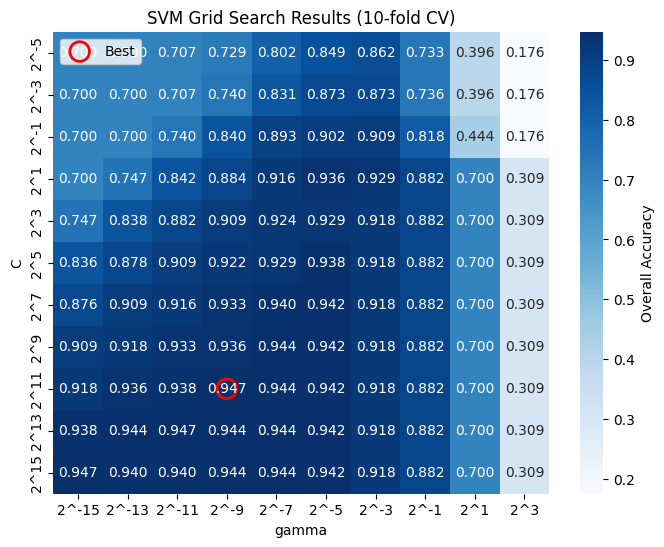

In [10]:
# Plotting
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(
    gsfit,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    xticklabels=[f"2^{int(np.log2(g))}" for g in gcoef],
    yticklabels=[f"2^{int(np.log2(c))}" for c in ccoef],
    cbar_kws={'label': 'Overall Accuracy'}
)
plt.title('SVM Grid Search Results (10-fold CV)')
plt.xlabel('gamma')
plt.ylabel('C')


i = list(ccoef).index(best_C)
j = list(gcoef).index(best_gamma)

plt.scatter(
    j + 0.5,
    i + 0.5,
    s=200,
    facecolors='none',
    edgecolors='red',
    linewidths=2,
    label=f'Best'
)
plt.legend(loc='upper left')

plt.show()

### Q4.5 (2 pts): 
How do γ and C affect the model accuracy? Which γ and C yields the best model fit? 

**Answer:** Gamma affects the influence of individual data points on the decision boundary / how smooth the decision boundary is. Higher gamma values above 0.5 show reduced performance. Higher C values minimize misclassification errors, but by maintaining a small margin around the decision boundary (overfitting). Lower C values prioritize the margin around the decision boundary, but at the cost of underfitting (here lower accuracy below 0.5 C). 

In [11]:
# Similar to tune() there is an implemented GridSearch in sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

param_grid = {
    'svc__C': 2.0 ** np.arange(-5, 16, 2),
    'svc__gamma': 2.0 ** np.arange(-15, 4, 2)
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', svm.SVC(kernel='rbf'))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy')
grid_search.fit(cal_ref, cal_class_values)

tuned_C = grid_search.best_params_['svc__C']
tuned_gamma = grid_search.best_params_['svc__gamma']
best_accuracy = grid_search.best_score_

print("Best C: 2^", int(np.log2(tuned_C)), "Best Gamma: 2^", int(np.log2(tuned_gamma)))
print("Best Accuracy:", best_accuracy)

Best C: 2^ 11 Best Gamma: 2^ -9
Best Accuracy: 0.9466666666666667


### Q4.6 (2 pts): 
How do the tuned γ and C differ from the outcome of your own grid search? Which overall
accuracy do they yield?

**Answer:** The tuned γ and C from GridSearchCV match the results of the manual grid search, as both methods do essentially the same. They yield the same overall accuracy and take the same runtime.

## Building the final SVM model

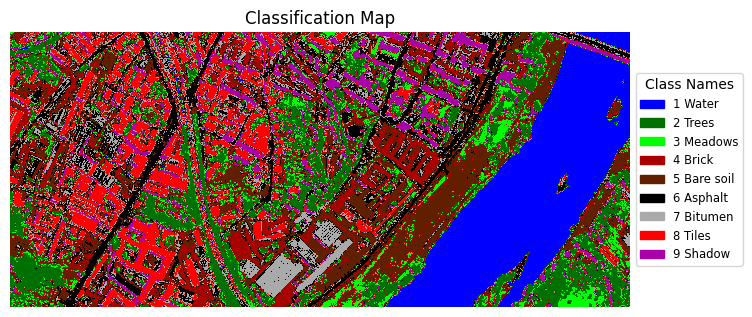

In [12]:
from matplotlib.colors import ListedColormap

best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', svm.SVC(kernel='rbf', gamma=tuned_gamma, C=tuned_C))
])

best_pipeline.fit(cal_ref, cal_class_values)

# Reshape (pixels, bands)
n_bands, n_rows, n_cols = image_data.shape
image_data_reshaped = image_data.reshape(n_bands, -1).T

predictions = best_pipeline.predict(image_data_reshaped)

prediction_map = predictions.reshape(n_rows, n_cols)

cmap = ListedColormap(colors)

plt.figure(figsize=(8, 8))
plt.imshow(np.rot90(prediction_map, k=-1), cmap=cmap)
plt.title('Classification Map')
plt.axis('off')

plt.legend(handles=legend_handles, loc='center left', fontsize='small', ncol=1, title="Class Names", bbox_to_anchor=(1, 0.5))
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix

val_sf = shapefile.Reader(f"{path}/rosis_valpoints.shp")

val_cols, val_rows, val_x, val_y, val_class_values = extract(val_sf)
val_class = np.array(val_class_values)

print(val_class.shape)

# predicted classes val points
val_predictions = []
for col, row in zip(val_cols, val_rows):
    val_predictions.append(prediction_map[row, col])

cfm = confusion_matrix(val_class, val_predictions, labels=np.unique(val_class))

# reordering not necessary, confusion_matrix returns rows and columns in the order of the labels

print("Confusion Matrix:")
print(cfm)

oac = round(np.sum(np.diag(cfm)) / np.sum(cfm), 3)
print(f"Overall Accuracy: {oac}")

(450,)
Confusion Matrix:
[[50  0  0  0  0  0  0  0  0]
 [ 0 48  2  0  0  0  0  0  0]
 [ 0  4 43  0  3  0  0  0  0]
 [ 0  0  0 46  3  0  0  1  0]
 [ 0  0  0  1 49  0  0  0  0]
 [ 0  0  0  1  0 44  5  0  0]
 [ 0  0  0  4  0  2 44  0  0]
 [ 0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0 50]]
Overall Accuracy: 0.942


In [14]:
def get_accuracies(confmatrix):
    users_acc = np.round(np.diag(confmatrix) / np.sum(confmatrix, axis=1), 2)
    users_acc_dict = dict(zip(class_names, users_acc))

    print("User's Accuracy for each class:")
    for class_name, acc in users_acc_dict.items():
        print(f"{class_name}: {acc}")

    producers_acc = np.round(np.diag(confmatrix) / np.sum(confmatrix, axis=0), 2)
    producers_acc_dict = dict(zip(class_names, producers_acc))

    print("\nProducer's Accuracy for each class:")
    for class_name, acc in producers_acc_dict.items():
        print(f"{class_name}: {acc}")

get_accuracies(cfm)

User's Accuracy for each class:
1 Water: 1.0
2 Trees: 0.96
3 Meadows: 0.86
4 Brick: 0.92
5 Bare soil: 0.98
6 Asphalt: 0.88
7 Bitumen: 0.88
8 Tiles: 1.0
9 Shadow: 1.0

Producer's Accuracy for each class:
1 Water: 1.0
2 Trees: 0.92
3 Meadows: 0.96
4 Brick: 0.88
5 Bare soil: 0.89
6 Asphalt: 0.96
7 Bitumen: 0.9
8 Tiles: 0.98
9 Shadow: 1.0


### Q4.7 (1 pts): 
Which classes show the lowest accuracies? Does this meet your expectations based on Q4.3?

**Answer:** As expected, Water, Tiles and Shadow have the best accuracies, as their spectras were visibly distinct from the others. The others show lower accuracies, with Bitumen (confused with Asphalt) and Brick (confused with Bare Soil) the lowest. 

## Comparison to randomForest

### Q4.8 (3 pts): 
Build a random forest classification model for the Pavia data and perform an accuracy
assessment as for the SVM model above. Provide the code for this operation.

In [15]:
# some parameter tuning (because we also did it with the svm; but for svm more useful)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'min_samples_split': [2, 4], 
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss']
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(cal_ref, cal_class_values)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy: 0.9088888888888889


In [20]:
# best parameter are actually almost the default values
best_rf = RandomForestClassifier(n_estimators=500, criterion='entropy', oob_score=True, random_state=42)

best_rf.fit(cal_ref, cal_class_values)

predictions_rf = best_rf.predict(image_data_reshaped)

prediction_map_rf = predictions_rf.reshape(n_rows, n_cols)

# predicted classes val points
val_predictions_rf = []
for col, row in zip(val_cols, val_rows):
    val_predictions_rf.append(prediction_map_rf[row, col])

cfm_rf = confusion_matrix(val_class, val_predictions_rf, labels=np.unique(val_class))

print("Confusion Matrix:")
print(cfm_rf)

oac = round(np.sum(np.diag(cfm_rf)) / np.sum(cfm_rf), 3)
print(f"Overall Accuracy: {oac}")

get_accuracies(cfm_rf)
differences = cfm - cfm_rf
print(differences)

Confusion Matrix:
[[49  0  0  0  0  1  0  0  0]
 [ 0 47  3  0  0  0  0  0  0]
 [ 0  3 45  0  2  0  0  0  0]
 [ 0  0  0 44  2  0  3  1  0]
 [ 0  0  0  4 44  0  0  2  0]
 [ 0  0  0  2  0 43  5  0  0]
 [ 0  0  0  7  0  4 39  0  0]
 [ 1  0  0  0  1  1  0 47  0]
 [ 1  0  0  0  0  0  0  0 49]]
Overall Accuracy: 0.904
User's Accuracy for each class:
1 Water: 0.98
2 Trees: 0.94
3 Meadows: 0.9
4 Brick: 0.88
5 Bare soil: 0.88
6 Asphalt: 0.86
7 Bitumen: 0.78
8 Tiles: 0.94
9 Shadow: 0.98

Producer's Accuracy for each class:
1 Water: 0.96
2 Trees: 0.94
3 Meadows: 0.94
4 Brick: 0.77
5 Bare soil: 0.9
6 Asphalt: 0.88
7 Bitumen: 0.83
8 Tiles: 0.94
9 Shadow: 1.0
[[ 1  0  0  0  0 -1  0  0  0]
 [ 0  1 -1  0  0  0  0  0  0]
 [ 0  1 -2  0  1  0  0  0  0]
 [ 0  0  0  2  1  0 -3  0  0]
 [ 0  0  0 -3  5  0  0 -2  0]
 [ 0  0  0 -1  0  1  0  0  0]
 [ 0  0  0 -3  0 -2  5  0  0]
 [-1  0  0  0 -1 -1  0  3  0]
 [-1  0  0  0  0  0  0  0  1]]


### Q4.9 (2 pts): 
Compare the SVM results to the RF results. How do you judge the performance of the
approaches?

**Answer:** Overall Accuracy 0.942 for SVM and only 0.904 for RF. 

Users Accuracy: SVM shows improvement in most classes, especially for Bare soil  (0.88 vs 0.98) and Bitumen (0.78 vs 0.88). RF slightly outperforms SVM for Meadows (0.9 vs 0.86).

Producers Accuracy: SVM significantly improves on Brick (0.77 vs 0.88), Asphalt (0.88 vs 0.96), and Bitumen (0.83 vs 0.9).
RF performs slightly better for Trees (-0.02) and Bare soil (-0.01).

Overall, SVM shows superior performance. While both models are effective, SVM is here the preferred choice.

### Q4.10 (3 pts): 
Read the paper by De Boissieu et al. (2018). The authors claim in paragraph 3.2.3 that 'SVM can
work with small training datasets (...) with classes having less than 50 samples.' Does this promise hold
true? Take a random subsample of the Pavia data with approximately 30 calibration points per class and
repeat the SVM modeling. How does the smaller sample size affect the model performance? Does the
Hughes Phenomenonen (i.e., the curse of dimensionality) apply or are there signs of over fitting?

In [ ]:
from collections import Counter
import random

#print(Counter(cal_class_values))
#print(cal_class_values) #actually sorted

def get_training_data(subset_per_class):
    num_classes = 9
    samples_per_class = 50

    selected_indices = []

    for cls in range(1, num_classes + 1):
        # calculate start and end for the current class
        start_idx = (cls - 1) * samples_per_class
        end_idx = cls * samples_per_class
        class_indices = list(range(start_idx, end_idx))
        
        # Sample subset from the current class
        sampled = random.sample(class_indices, subset_per_class)
        selected_indices.extend(sampled)

    X_train_subset = cal_ref[selected_indices]
    y_train_subset = np.array([cal_class_values[i] for i in selected_indices])

    return X_train_subset, y_train_subset

    #print(Counter(y_train_subset))

In [18]:
from tqdm import tqdm
subset_sizes = [50 - j*5 for j in range(10)]
train_accuracies = []
test_accuracies = []

for sample_size in tqdm(subset_sizes, desc="Training and Testing"):
    best_pipeline_small = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', svm.SVC(kernel='rbf', gamma=tuned_gamma, C=tuned_C))
    ])

    X, y = get_training_data(sample_size)
    best_pipeline_small.fit(X, y)

    train_predictions = best_pipeline_small.predict(X)
    cfm_train = confusion_matrix(y, train_predictions, labels=np.unique(y))
    oac_train = round(np.sum(np.diag(cfm_train)) / np.sum(cfm_train), 3)

    predictions_small = best_pipeline_small.predict(image_data_reshaped)
    prediction_map_small = predictions_small.reshape(n_rows, n_cols)

    val_predictions_small = []
    for col, row in zip(val_cols, val_rows):
        val_predictions_small.append(prediction_map_small[row, col])

    cfm_test = confusion_matrix(val_class, val_predictions_small, labels=np.unique(val_class))
    oac_test = round(np.sum(np.diag(cfm_test)) / np.sum(cfm_test), 3)

    train_accuracies.append(oac_train)
    test_accuracies.append(oac_test)
print(train_accuracies)
print(test_accuracies)


Training and Testing: 100%|██████████| 10/10 [03:54<00:00, 23.46s/it]

[0.998, 1.0, 0.997, 0.997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.942, 0.942, 0.938, 0.936, 0.927, 0.924, 0.916, 0.929, 0.889, 0.831]


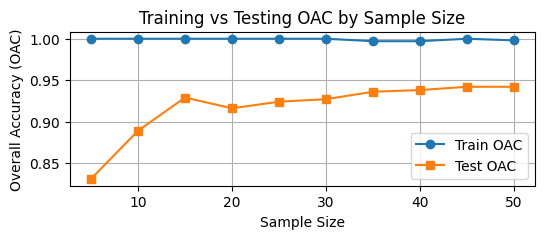

In [19]:
plt.figure(figsize=(6, 2))
plt.plot(subset_sizes, train_accuracies, label='Train OAC', marker='o')
plt.plot(subset_sizes, test_accuracies, label='Test OAC', marker='s')
plt.xlabel('Sample Size')
plt.ylabel('Overall Accuracy (OAC)')
plt.title('Training vs Testing OAC by Sample Size')
plt.legend()
plt.grid(True)
plt.show()

**Answer:** As can be seen in the graph, the promise that SVM works well with small datasets holds true only partially. While it performs reasonably well with ~30 samples per class (test oac = 0.927), performance degrades visibly for datasets smaller than 45 per sample.
    The Hughes phenomenon is apparent for very small sample sizes (e.g. <=10) due to high dimensionality (102) relative to available data (10*9 points).
    Overfitting occurs for smaller datasets, as presented by perfect training accuracy and lower test accuracy.


### Q4.11 (3pts):
Come up with one (or more) additional questions of your own that address(es) the paper and its
methodology.

**My Question:** 

The paper mentions in the abstract that "spectral features extraction can rapidly reduce data complexity by [both] targeting only the diagnostic mineral absorptions [and masking those pixels complicated by vegetation, cloud, and deep shade.]"

 In detail, the authors describe the process of absorption parameterization, where the wavelength and depth of maximum absorption for each mineral are determined using a 4th order polynomial. This method identifies spectral features such as D660 D 900 W900 D2120 D2310. The choice of these specific spectral features can significantly influence the outcomes and accuracy of the mapping.

How does this method compare to other feature extraction techniques, such as using wavelength importance (e.g. as seen in the random forest classifier) or feature transformation approaches (e.g. dimensionality reduction with PCA, autoencoders)? Could their method miss important geological details that could be captured by other techniques, or might it be better suited for their use case?
